# Data Loading and Preprocessing Pipeline Demo

This notebook demonstrates the complete data preprocessing pipeline for shuttle tracking data:
1. Load vehicle locations from database/CSV
2. Convert timestamps to epoch seconds
3. Add closest route information
4. Compute distance deltas
5. Compute speed
6. Segment into consecutive trips
7. Visualize speed over time for a single segment

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import preprocessing functions
from ml.pipelines import preprocess_pipeline
from ml.data.preprocess import segment_by_consecutive

## Step 1: Load and Preprocess Data

The `preprocess_pipeline()` function runs all preprocessing steps and caches the result.

In [7]:
# Load preprocessed data (uses cache if available)
df = preprocess_pipeline(force_recompute=False)

print(f"Loaded {len(df)} location points")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData shape: {df.shape}")

Loading preprocessed data from /Users/joel/eclipse-workspace/shuttletracker-new/ml/data/preprocessed_vehicle_locations.csv
Loaded 1833872 preprocessed records from cache
Loaded 1833872 location points

Columns: ['vehicle_id', 'latitude', 'longitude', 'timestamp', 'epoch_seconds', 'dist_to_route', 'route', 'closest_lat', 'closest_lon', 'polyline_idx', 'distance_km', 'speed_kmh']

Data shape: (1833872, 12)


In [8]:
# Display first few rows
df.head(10)

,vehicle_id,latitude,longitude,timestamp,epoch_seconds,dist_to_route,route,closest_lat,closest_lon,polyline_idx,distance_km,speed_kmh
0,281474977379809,42.730284,-73.676562,2025-07-31 15:53:49.141,1.828763e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,281474977371235,42.723882,-73.680926,2025-07-31 15:55:27.052,1.828773e+07,0.001679,WEST,42.723890,-73.680908,2.0,NaN,NaN
2,281474977371235,42.724508,-73.681213,2025-07-31 15:55:33.027,1.828773e+07,0.001747,WEST,42.724515,-73.681194,2.0,0.073295,44.161098
3,281474977371235,42.725621,-73.681507,2025-07-31 15:55:44.248,1.828774e+07,0.000072,WEST,42.725621,-73.681506,2.0,0.125624,40.303587
4,281474977371235,42.726247,-73.681568,2025-07-31 15:55:50.028,1.828775e+07,0.000630,WEST,42.726246,-73.681576,2.0,0.069692,43.406696
5,281474977371235,42.726762,-73.681983,2025-07-31 15:55:55.999,1.828776e+07,0.003545,WEST,42.726732,-73.681998,2.0,0.064071,38.629176
6,281474977371235,42.727014,-73.682665,2025-07-31 15:56:01.021,1.828776e+07,0.005010,WEST,42.726970,-73.682679,2.0,0.061645,44.189646
7,281474977371235,42.727261,-73.683403,2025-07-31 15:56:06.019,1.828777e+07,0.004937,WEST,42.727218,-73.683417,2.0,0.066288,47.746367
8,281474977371235,42.727473,-73.684111,2025-07-31 15:56:11.521,1.828777e+07,0.003928,WEST,42.727438,-73.684119,2.0,0.062367,40.807045
9,281474977371235,42.727602,-73.684729,2025-07-31 15:56:17.045,1.828778e+07,0.003714,WEST,42.727568,-73.684735,2.0,0.052296,34.081354


## Step 2: Basic Data Summary

In [9]:
# Summary statistics
print("Summary Statistics:")
print("="*60)
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Number of vehicles: {df['vehicle_id'].nunique()}")

# Handle NaN values in route column
route_values = df['route'].dropna().unique()
print(f"Number of routes: {len(route_values)}")
print(f"\nRoutes: {sorted(route_values)}")

# Count NaN routes
nan_routes = df['route'].isna().sum()
print(f"Unmatched locations (no route): {nan_routes} ({nan_routes/len(df)*100:.2f}%)")

print(f"\nSpeed statistics (km/h):")
print(df['speed_kmh'].describe())

Summary Statistics:
Date range: 2025-07-31 15:53:49.141000 to 2025-12-25 01:24:05
Number of vehicles: 27
Number of routes: 2

Routes: ['NORTH', 'WEST']
Unmatched locations (no route): 1056927 (57.63%)

Speed statistics (km/h):
count    118755.000000
mean         27.261631
std          17.047553
min           0.000000
25%          13.145510
50%          30.902709
75%          39.348896
max         119.955909
Name: speed_kmh, dtype: float64


## Step 3: Segment into Consecutive Trips

Segments are created based on:
- Vehicle ID changes
- Time gaps > max_timedelta seconds

In [10]:
# Segment the data with 5-minute maximum time gap
max_timedelta = 300  # 5 minutes
segmented_df = segment_by_consecutive(df, max_timedelta=max_timedelta, segment_column='segment_id')

num_segments = segmented_df['segment_id'].nunique()
print(f"Created {num_segments} segments with max time gap of {max_timedelta}s ({max_timedelta/60:.1f} minutes)")

# Segment size distribution
segment_sizes = segmented_df.groupby('segment_id').size()
print(f"\nSegment size statistics:")
print(segment_sizes.describe())

Created 15515 segments with max time gap of 300s (5.0 minutes)

Segment size statistics:
count    15515.000000
mean       118.199936
std        182.769661
min          1.000000
25%          8.000000
50%         95.000000
75%        120.000000
max       2578.000000
dtype: float64


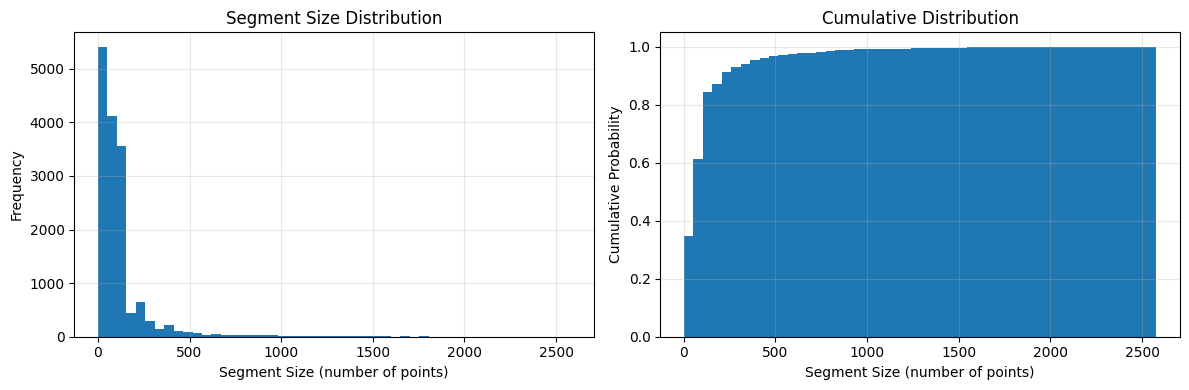


Segments with >= 10 points: 11483 (74.0%)
Segments with >= 20 points: 10949 (70.6%)
Segments with >= 50 points: 10143 (65.4%)


In [11]:
# Plot segment size distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
segment_sizes.hist(bins=50)
plt.xlabel('Segment Size (number of points)')
plt.ylabel('Frequency')
plt.title('Segment Size Distribution')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
segment_sizes.hist(bins=50, cumulative=True, density=True)
plt.xlabel('Segment Size (number of points)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSegments with >= 10 points: {(segment_sizes >= 10).sum()} ({(segment_sizes >= 10).sum() / len(segment_sizes) * 100:.1f}%)")
print(f"Segments with >= 20 points: {(segment_sizes >= 20).sum()} ({(segment_sizes >= 20).sum() / len(segment_sizes) * 100:.1f}%)")
print(f"Segments with >= 50 points: {(segment_sizes >= 50).sum()} ({(segment_sizes >= 50).sum() / len(segment_sizes) * 100:.1f}%)")

## Step 4: Select and Visualize One Segment

Let's select a segment with a reasonable number of points and visualize its speed over time.

In [12]:
# Filter to segments with valid routes (no NaN)
segmented_with_routes = segmented_df[segmented_df['route'].notna()].copy()
valid_segment_sizes = segmented_with_routes.groupby('segment_id').size()

# Find segments with at least 20 points for better visualization
large_segments = valid_segment_sizes[valid_segment_sizes >= 20].index

if len(large_segments) == 0:
    print("No segments with >= 20 points and valid routes found. Using largest valid segment.")
    selected_segment_id = valid_segment_sizes.idxmax()
else:
    # Select a segment from the middle of the dataset
    selected_segment_id = large_segments[len(large_segments) // 2]

# Extract the selected segment
segment = segmented_with_routes[segmented_with_routes['segment_id'] == selected_segment_id].copy()
segment = segment.sort_values('timestamp').reset_index(drop=True)

print(f"Selected segment {selected_segment_id}")
print(f"Number of points: {len(segment)}")
print(f"Vehicle ID: {segment['vehicle_id'].iloc[0]}")
print(f"Route: {segment['route'].iloc[0]}")
print(f"Time range: {segment['timestamp'].iloc[0]} to {segment['timestamp'].iloc[-1]}")
print(f"Duration: {(segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60:.1f} minutes")

Selected segment 7547
Number of points: 45
Vehicle ID: 281474979530259
Route: WEST
Time range: 2025-08-28 02:11:08.094000 to 2025-08-28 02:23:20.088000
Duration: 12.2 minutes


In [13]:
# Display segment data
segment[['timestamp', 'latitude', 'longitude', 'route', 'distance_km', 'speed_kmh']].head(10)

,timestamp,latitude,longitude,route,distance_km,speed_kmh
0,2025-08-28 02:11:08.094,42.730054,-73.677473,WEST,NaN,NaN
1,2025-08-28 02:11:14.044,42.729715,-73.677575,WEST,0.038674,23.399307
2,2025-08-28 02:11:19.016,42.729382,-73.677648,WEST,0.037280,26.992543
3,2025-08-28 02:11:24.039,42.728991,-73.677767,WEST,0.044593,31.960026
4,2025-08-28 02:12:16.066,42.727299,-73.678085,WEST,NaN,NaN
5,2025-08-28 02:12:27.087,42.727024,-73.678083,WEST,0.030943,10.107502
6,2025-08-28 02:12:38.157,42.727033,-73.678094,WEST,0.000838,0.272569
7,2025-08-28 02:12:51.028,42.727032,-73.678093,WEST,0.000147,0.041016
8,2025-08-28 02:12:56.023,42.726815,-73.678131,WEST,0.025137,18.116771
9,2025-08-28 02:13:02.005,42.726392,-73.678270,WEST,0.048830,29.386051


## Step 5: Visualize Speed Over Time

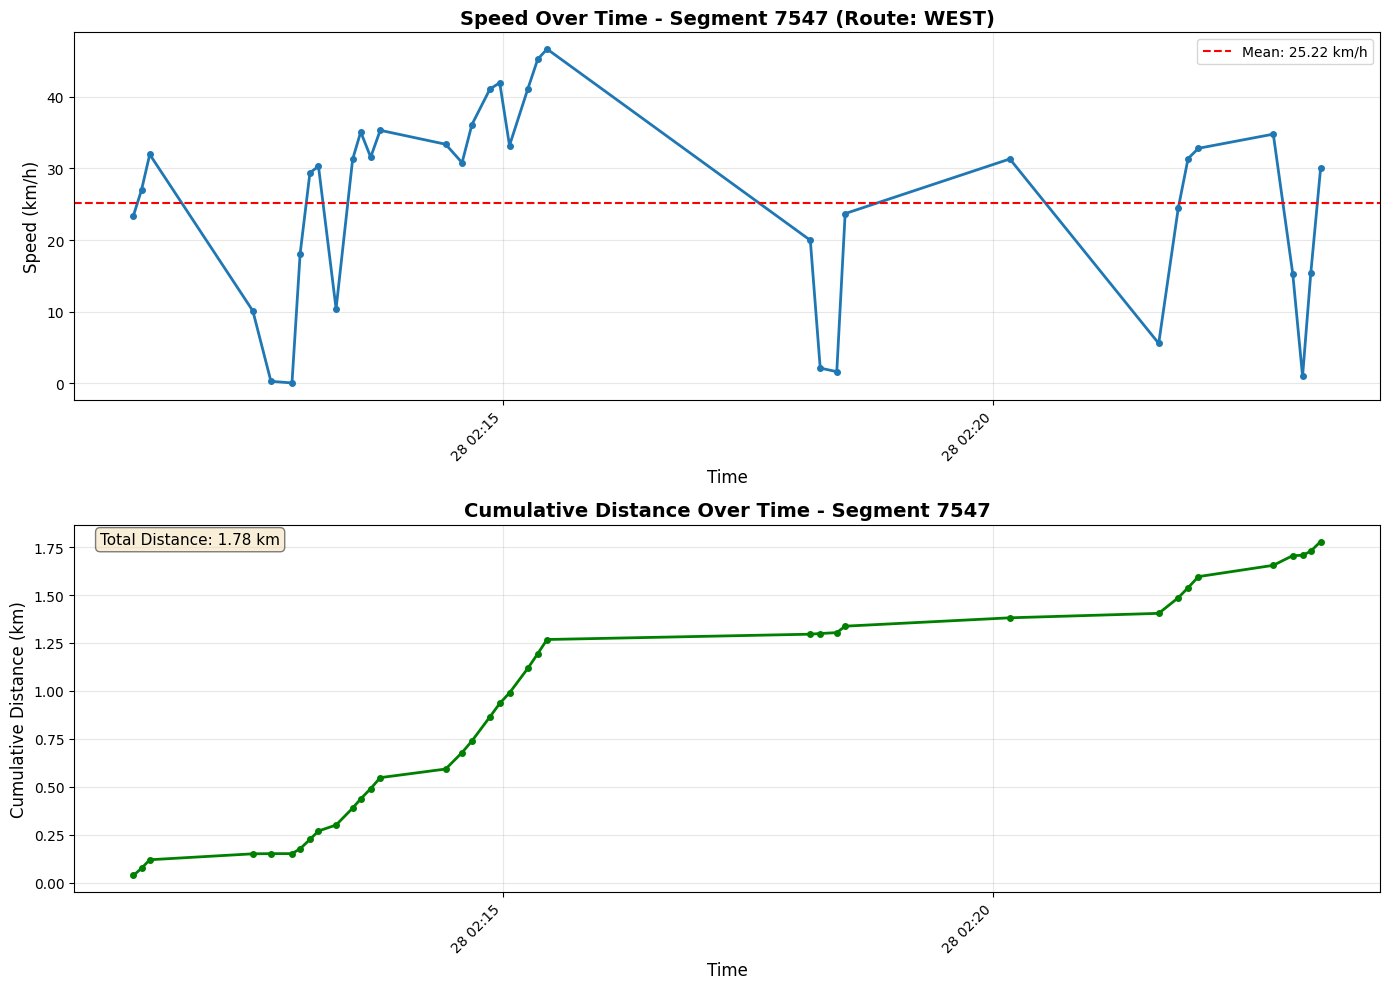


Speed Statistics for Segment 7547:
  Mean speed: 25.22 km/h
  Median speed: 30.31 km/h
  Max speed: 46.68 km/h
  Min speed: 0.04 km/h
  Std dev: 13.53 km/h
  Total distance: 1.78 km


In [14]:
# Create time-based plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Filter out NaN values for plotting
segment_clean = segment[segment['speed_kmh'].notna()].copy()

# Plot 1: Speed over time
ax1 = axes[0]
ax1.plot(segment_clean['timestamp'], segment_clean['speed_kmh'], marker='o', linestyle='-', linewidth=2, markersize=4)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Speed (km/h)', fontsize=12)
ax1.set_title(f'Speed Over Time - Segment {selected_segment_id} (Route: {segment["route"].iloc[0]})', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
mean_speed = segment_clean['speed_kmh'].mean()
ax1.axhline(y=mean_speed, color='r', linestyle='--', label=f'Mean: {mean_speed:.2f} km/h')
ax1.legend()

# Rotate x-axis labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Distance traveled over time (cumulative)
ax2 = axes[1]
cumulative_distance = segment_clean['distance_km'].cumsum()
ax2.plot(segment_clean['timestamp'], cumulative_distance, marker='o', linestyle='-', linewidth=2, markersize=4, color='green')
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Cumulative Distance (km)', fontsize=12)
ax2.set_title(f'Cumulative Distance Over Time - Segment {selected_segment_id}', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
total_distance = cumulative_distance.iloc[-1]
ax2.text(0.02, 0.98, f'Total Distance: {total_distance:.2f} km',
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Rotate x-axis labels
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"\nSpeed Statistics for Segment {selected_segment_id}:")
print(f"  Mean speed: {segment_clean['speed_kmh'].mean():.2f} km/h")
print(f"  Median speed: {segment_clean['speed_kmh'].median():.2f} km/h")
print(f"  Max speed: {segment_clean['speed_kmh'].max():.2f} km/h")
print(f"  Min speed: {segment_clean['speed_kmh'].min():.2f} km/h")
print(f"  Std dev: {segment_clean['speed_kmh'].std():.2f} km/h")
print(f"  Total distance: {total_distance:.2f} km")

## Step 6: Additional Visualization - Speed Distribution

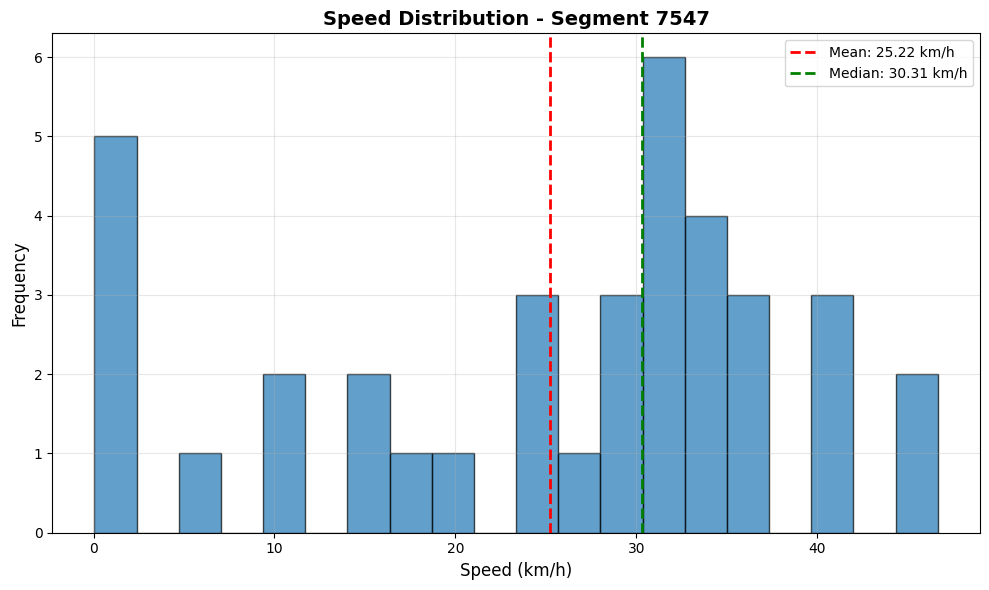

In [15]:
# Speed distribution histogram (using clean data without NaN)
segment_clean = segment[segment['speed_kmh'].notna()].copy()

plt.figure(figsize=(10, 6))
plt.hist(segment_clean['speed_kmh'], bins=20, edgecolor='black', alpha=0.7)
mean_speed = segment_clean['speed_kmh'].mean()
median_speed = segment_clean['speed_kmh'].median()
plt.axvline(mean_speed, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_speed:.2f} km/h')
plt.axvline(median_speed, color='g', linestyle='--', linewidth=2, label=f'Median: {median_speed:.2f} km/h')
plt.xlabel('Speed (km/h)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Speed Distribution - Segment {selected_segment_id}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Step 7: Geographic Visualization (Optional)

Plot the segment path on a simple coordinate plot.

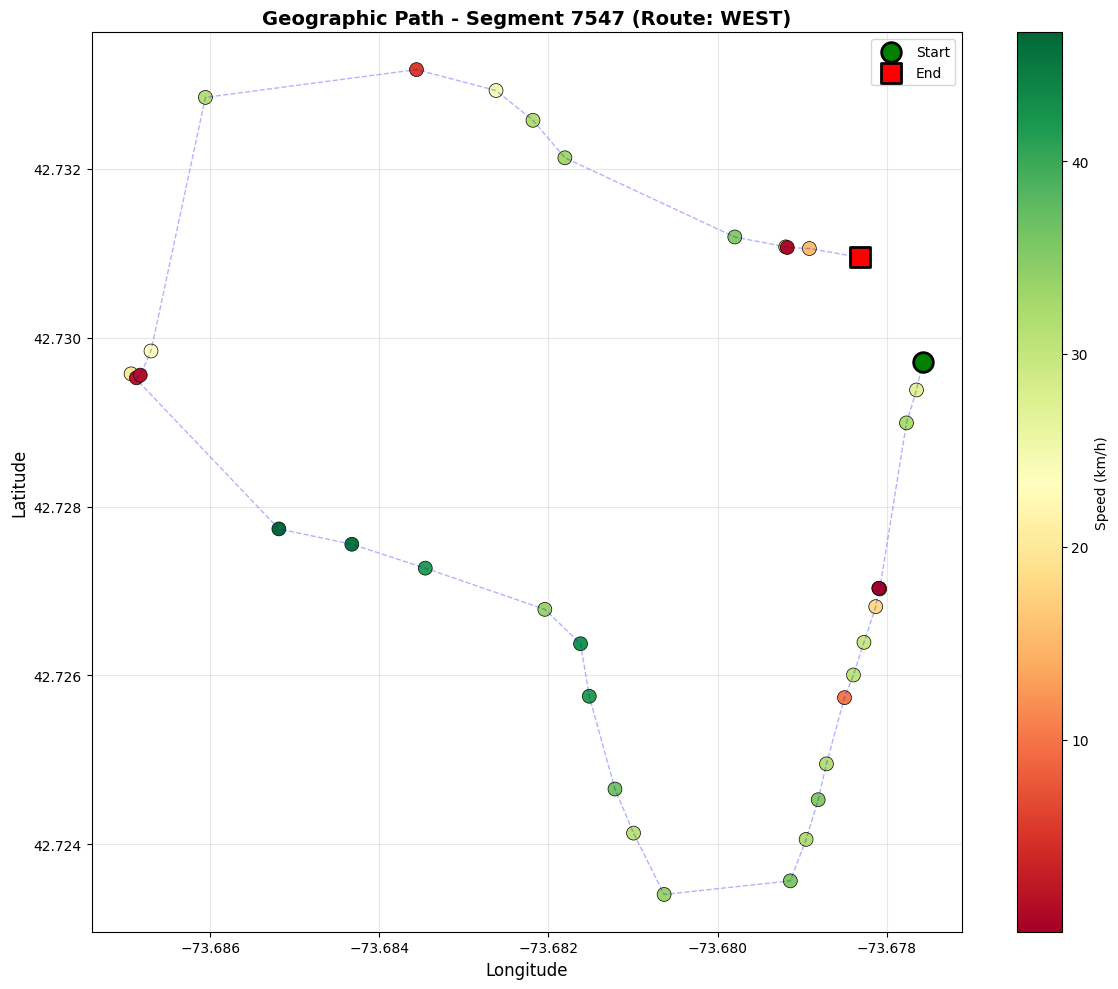

In [16]:
# Plot the geographic path with speed as color (using clean data without NaN)
segment_clean = segment[segment['speed_kmh'].notna()].copy()

plt.figure(figsize=(12, 10))

# Create a scatter plot with speed as color
scatter = plt.scatter(segment_clean['longitude'], segment_clean['latitude'],
                     c=segment_clean['speed_kmh'], cmap='RdYlGn',
                     s=100, edgecolors='black', linewidth=0.5)

# Add line connecting the points
plt.plot(segment_clean['longitude'], segment_clean['latitude'],
         color='blue', alpha=0.3, linewidth=1, linestyle='--')

# Mark start and end
plt.scatter(segment_clean['longitude'].iloc[0], segment_clean['latitude'].iloc[0],
           color='green', s=200, marker='o', edgecolors='black', linewidth=2, label='Start', zorder=5)
plt.scatter(segment_clean['longitude'].iloc[-1], segment_clean['latitude'].iloc[-1],
           color='red', s=200, marker='s', edgecolors='black', linewidth=2, label='End', zorder=5)

plt.colorbar(scatter, label='Speed (km/h)')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title(f'Geographic Path - Segment {selected_segment_id} (Route: {segment["route"].iloc[0]})',
         fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:
1. ✓ Loading preprocessed vehicle location data
2. ✓ Segmenting data into consecutive trips
3. ✓ Visualizing speed over time for a single segment
4. ✓ Analyzing speed distribution and geographic path

The preprocessing pipeline handles:
- Timestamp conversion to epoch seconds
- Route matching using closest point algorithm
- Distance calculation between consecutive points
- Speed calculation from distance and time
- Segmentation based on vehicle ID and time gaps

All preprocessing results are cached for efficient repeated use.